In [262]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
import numpy.ma as ma

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
import xesmf as xe

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

Read the different file types: pb-tags indicate pressure level files, pc-tags indicate pure surface files.
Past is 1980 vegetation, current is 2010. 
Topography and vegetation information is saved in ancillaries folder 'ancils'.

In [263]:
VERA_data_dir = '/home/ck/DIR/cornkle/data/vera_out/'

pl_files_current = glob.glob(VERA_data_dir+'current*pb*.nc')
pl_files_past = glob.glob(VERA_data_dir+'past*pb*.nc')
surface_files_current = glob.glob(VERA_data_dir+'current*pc*.nc')
surface_files_past = glob.glob(VERA_data_dir+'past*pc*.nc')
ancil_path = VERA_data_dir + 'ancils/'

In [264]:
srfc_cur = xr.open_mfdataset(surface_files_current)
srfc_past = xr.open_mfdataset(surface_files_past)
pl_cur = xr.open_mfdataset(pl_files_current)
pl_past = xr.open_mfdataset(pl_files_past)

In [265]:
# decode_times=False is needed because the ancils have no real time step and without it
# xarray would try to read the time, fail, and then give an error. With the keyword however you can read it. 

all_ancil =xr.open_dataset(ancil_path + 'ancils_vera.nc', decode_times=False) 

In [266]:
pl_cur

<xarray.Dataset>
Dimensions:                     (false_latitude: 380, false_longitude: 750, pressure_levels: 16, time: 480)
Coordinates:
  * false_latitude              (false_latitude) float64 -8.28 -8.244 ... 5.364
  * false_longitude             (false_longitude) float64 -14.6 -14.56 ... 12.36
    true_latitude               (false_latitude, false_longitude) float64 0.9178 ... 14.64
    true_longitude              (false_latitude, false_longitude) float64 -16.95 ... 10.23
  * pressure_levels             (pressure_levels) float64 975.0 950.0 ... 200.0
  * time                        (time) datetime64[ns] 2014-04-05T01:00:00 ... 2014-04-06
Data variables:
    lst                         (time, false_latitude, false_longitude) float32 dask.array<shape=(480, 380, 750), chunksize=(24, 380, 750)>
    q2                          (time, false_latitude, false_longitude) float32 dask.array<shape=(480, 380, 750), chunksize=(24, 380, 750)>
    T2                          (time, false_latitude,

In [267]:
def u_v_to_ws_wd(u,v):
    """
    This function computes wind speed and wind direction from given u,v wind components
    Wind direction indicates where the wind is coming from. 
    :param u:
    :param v:
    :return: tuple (wind speed, wind direction (convention "wind coming from")
    """

    ws = np.array(np.sqrt(u*u + v*v))
    wd = np.array(180. + np.arctan2(u, v) * 180./ np.pi)  # dir where wind is coming from
    pos = np.where(ws == 0)
    try:
        wd[pos] = np.nan
    except IndexError:
        pass

    return ws,wd

In [268]:
ucur = pl_cur['u10']   # data for wind example
vcur = pl_cur['v10']

upast = pl_past['u10']   # data for wind example
vpast = pl_past['v10']

In [269]:
rain = srfc_cur['TotalRain'] # NOTE: RAINFALL IS PER SECOND, NOT PER HOUR. HAS TO BE MULTIPLIED BY 3600 for mm/h
np.unique(rain['time.day'])

array([ 5,  6,  7,  8,  9, 10])

In [270]:
srfc_cur.TotalRain.values.max()*3600  ## rainfall check - looks fine.

87.02717497944832

(array([1594885.,  451716.,  254767.,  168638.,  115493.,   75754.,
          49726.,   33162.,   22007.]),
 array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
 <a list of 9 Patch objects>)

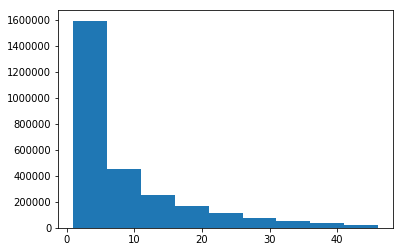

In [388]:
plt.hist((srfc_cur.TotalRain.values.flatten())*3600, bins=np.arange(1,51,5)) # rainfall disribution

In [272]:
# In this step we read a variable and wind components for later plotting. Both variables are grouped by
# hours and averaged over all available 6 days.

cur = srfc_cur['TotalRain'].groupby('time.hour').mean('time')*3600   ### input variable for plotting below
past = srfc_past['TotalRain'].groupby('time.hour').mean('time')*3600

ucur = ucur.groupby('time.hour').mean('time')  ## wind for plotting below
vcur = vcur.groupby('time.hour').mean('time')

upast = upast.groupby('time.hour').mean('time')  ## wind for plotting below
vpast = vpast.groupby('time.hour').mean('time')

In [273]:
cur

<xarray.DataArray 'TotalRain' (hour: 24, false_latitude: 380, false_longitude: 750)>
dask.array<shape=(24, 380, 750), dtype=float32, chunksize=(1, 380, 750)>
Coordinates:
  * false_latitude   (false_latitude) float64 -8.28 -8.244 ... 5.328 5.364
  * false_longitude  (false_longitude) float64 -14.6 -14.56 ... 12.33 12.36
    true_latitude    (false_latitude, false_longitude) float64 0.9178 ... 14.64
    true_longitude   (false_latitude, false_longitude) float64 -16.95 ... 10.23
  * hour             (hour) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23

In [381]:
# calculate wind speed and direction from u/v 
wscur, wdircur = u_v_to_ws_wd(ucur,vcur)

uano = ucur-upast
vano = vcur-vpast  # wind changes

In [382]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

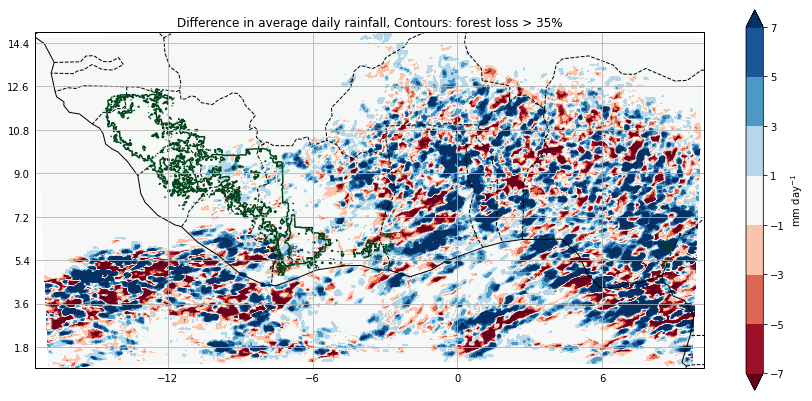

In [389]:
lon=srfc_cur.true_longitude
lat=srfc_cur.true_latitude
data=(cur-past).sel(hour=slice(0,23)).sum('hour')  
data2=all_ancil['veg_current']-all_ancil['veg_past']
title='Difference in average daily rainfall, Contours: forest loss > 35%'

contour = {'data' : data2*100, 'x' : lon, 'y' : lat, 'levels' : [ -40, -35], 'cmap' : 'Greens'}


draw_map(data, lon, lat, title=title, levels=np.linspace(-7,7,8), extend='both', cmap='RdBu', contour=contour, cbar_label= 'mm day$^{-1}$')

## Note that rainfall differences are very noisy!
## Note also that we barely get any rainfall at all (current or past!) in the deforestation region in our simulations..

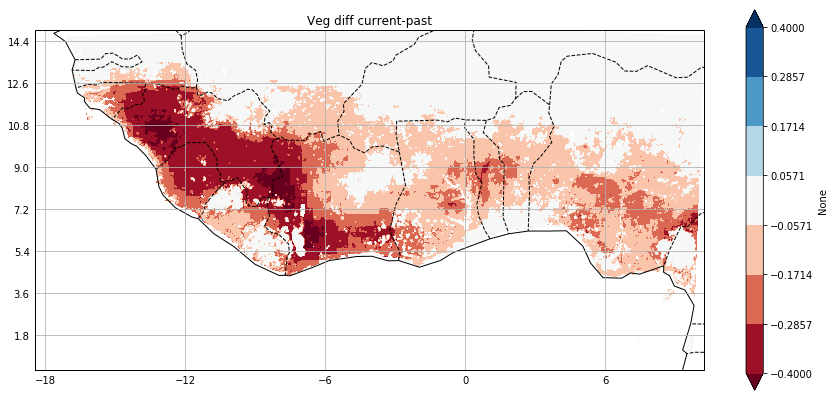

In [384]:
draw_map(data2, lon, lat, title='Veg diff current-past', levels=np.linspace(-0.4,0.4,8), extend='both', cmap='RdBu')

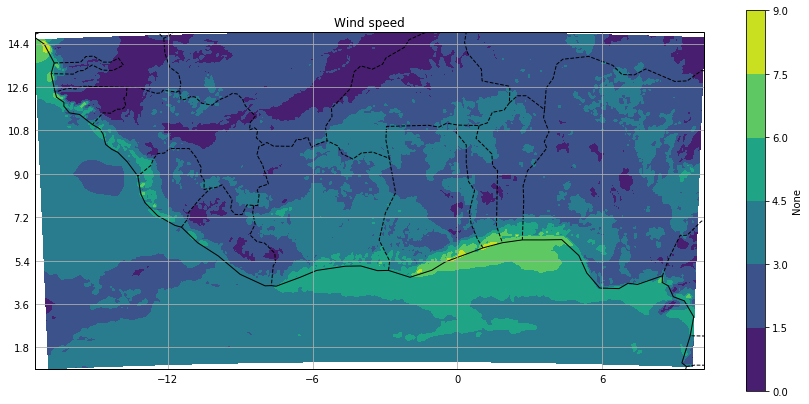

In [385]:
draw_map(wscur[15,:,:],lon,lat, title='Wind speed')

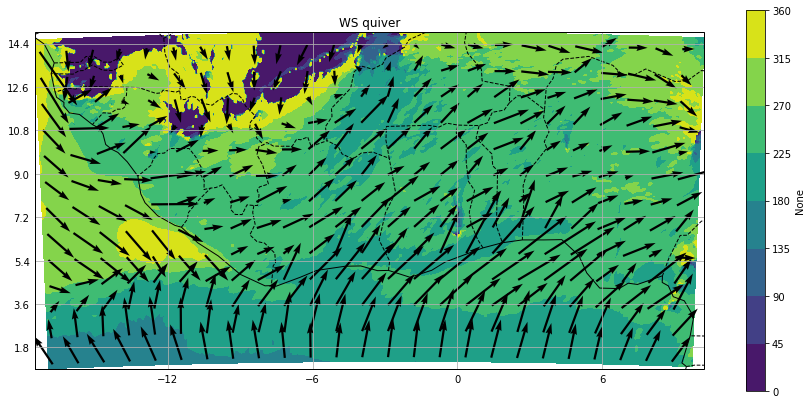

In [386]:
# preparation of wind vector data in plot
st=30
sarrow = 5
xquiv = ucur.true_longitude[sarrow::st, sarrow::st]
yquiv = ucur.true_latitude[sarrow::st, sarrow::st]

uu = (ucur[15,:,:])[sarrow::st, sarrow::st]
vv = (vcur[15,:,:])[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 70}


draw_map(wdircur[15,:,:], lon, lat, title='WS quiver', quiver=qin,levels=np.arange(0,361,45))

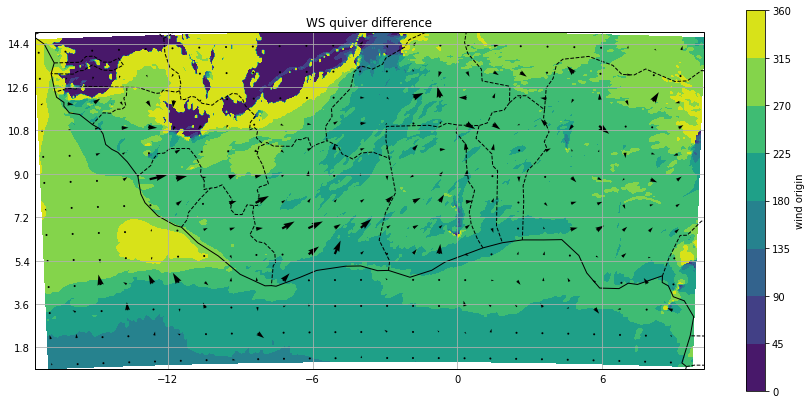

In [387]:
# differences in wind vectors
st=30
sarrow = 4
xquiv = ucur.true_longitude[sarrow::st, sarrow::st]
yquiv = ucur.true_latitude[sarrow::st, sarrow::st]

uu = (uano[15,:,:])[sarrow::st, sarrow::st]  # wind differences
vv = (vano[15,:,:])[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 60}


draw_map(wdircur[15,:,:], lon, lat, title='WS quiver difference', quiver=qin,levels=np.arange(0,361,45), cbar_label='wind origin')

In [21]:
# Grouping runs of current and past to do individual aggregation

current_runs = ['xmhkga', 'xmhkka', 'xmhkma', 'xmhkoa']
past_runs = ['xmhkja', 'xmhkla', 'xmhkna', 'xmhkpa']

In [22]:
diff_da = None
var = 'SH'
if var == 'TotalRain':
    c=3600
else:
    c=1
    
def collect(container, data, dim_name):
    if container is not None:
        container = xr.concat([container,data], dim_name)
    else:
        container = data
    
    return container

arstack_cur = None
arstack_past = None 

for cur, pas in zip(current_runs, past_runs):
    surface_files_current = glob.glob(VERA_data_dir+'current_'+cur+'.pc*.nc')
    surface_files_past = glob.glob(VERA_data_dir+'past_'+pas+'.pc*.nc')
    
    dummy_cur = xr.open_mfdataset(surface_files_current)
    dummy_past = xr.open_mfdataset(surface_files_past)
    
#     cur_data = dummy_cur[var].sel(pressure_levels=900).groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
#     past_data = dummy_past[var].sel(pressure_levels=900).groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')

    cur_data = dummy_cur[var].groupby('time.hour').mean('time').sel(hour=slice(6,21)).mean('hour')
    past_data = dummy_past[var].groupby('time.hour').mean('time').sel(hour=slice(6,21)).mean('hour')


    arstack_cur = collect(arstack_cur, cur_data*c, 'cur') ## individual ensemble members are stacked in one array for subsequent t-test per pixel.
    arstack_past = collect(arstack_past, past_data*c, 'past')


In [23]:
arstack_past

<xarray.DataArray 'SH' (past: 4, false_latitude: 380, false_longitude: 750)>
dask.array<shape=(4, 380, 750), dtype=float32, chunksize=(1, 380, 750)>
Coordinates:
  * false_latitude   (false_latitude) float64 -8.28 -8.244 ... 5.328 5.364
  * false_longitude  (false_longitude) float64 -14.6 -14.56 ... 12.33 12.36
    true_latitude    (false_latitude, false_longitude) float64 0.9178 ... 14.64
    true_longitude   (false_latitude, false_longitude) float64 -16.95 ... 10.23
Dimensions without coordinates: past

In [391]:
## t-test for equal means of past and current ensemble (based on a sample size of 4..not very robust..)
tstat, pval = stats.ttest_ind(arstack_cur, arstack_past, axis=0) 
amask = (pval<=0.01).astype(int)  # test pvalue significance level at 0.01

In [26]:
meancur=arstack_cur.mean('cur')
meanpast = arstack_past.mean('past')

/home/ck/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


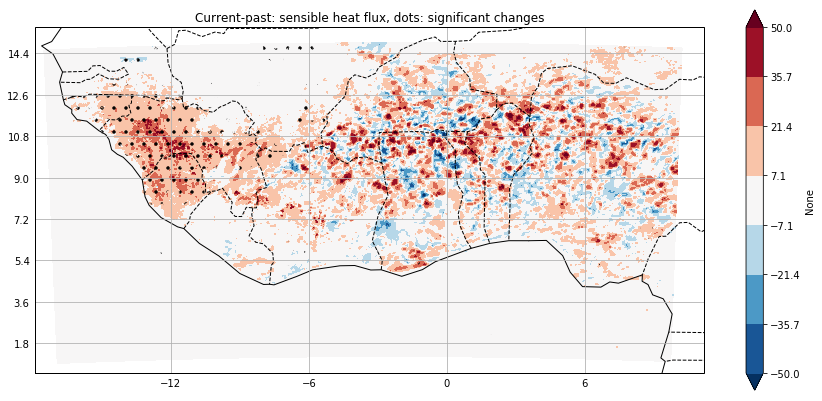

In [328]:
## plot with dots indicating significant changes based on t-test
draw_map(meancur-meanpast, meancur.true_longitude, meancur.true_latitude, title='Current-past: sensible heat flux, dots: significant changes', levels=np.linspace(-50,50,8), extend='both', cmap='RdBu_r', mask_sig=amask)

In [28]:
# manually create a 0.25deg grid for regular-grid interpolation. This will be our new lat/lon grid
new_lon = np.arange(-17,10.1,0.25)
new_lat = np.arange(1,14.1,0.25)

X, Y = np.meshgrid(new_lon, new_lat)
X.shape

(53, 109)

In [29]:
# we need to create an xarray dataset with the lat/lon coordinates of the grid we want to interpolate to!
new_grid = xr.Dataset({'lat': (['y', 'x'], Y),
                     'lon': (['y', 'x'], X)}, coords={'x' : np.arange(X.shape[1]), 'y' : np.arange(X.shape[0])})

In [30]:
# check our new grid
new_grid

<xarray.Dataset>
Dimensions:  (x: 109, y: 53)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 100 101 102 103 104 105 106 107 108
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 43 44 45 46 47 48 49 50 51 52
Data variables:
    lat      (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 14.0 14.0 14.0 14.0 14.0
    lon      (y, x) float64 -17.0 -16.75 -16.5 -16.25 ... 9.25 9.5 9.75 10.0

In [32]:
# we need to provide the true lat/lon 2d fields to the regridder. Those must be named "lat" and "lon"
# Otherwise the regridder routine can't identify the correct coordinates
dummy = srfc_cur['SH']
dummy = dummy.rename({'true_latitude':'lat', 'true_longitude' : 'lon'})  

In [33]:
# use regridder routine. This routine calculates weights for the regridding from grid A to grid B. 
# Since all variables are regridded from the same grid A to the same grid B, we only calculate the weights once
# and then use it for all variables. This saves a lot of computing time!

regridder = xe.Regridder(dummy, new_grid, 'bilinear')
regridder  # print basic regridder information.

Overwrite existing file: bilinear_380x750_53x109.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_380x750_53x109.nc 
Reuse pre-computed weights? False 
Input grid shape:           (380, 750) 
Output grid shape:          (53, 109) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      False

In [34]:
# read datasets again for fresh regridding
cur = pl_cur.groupby('time.hour').mean('time').sel(hour=slice(15,17)).mean('hour')   ### input variable for plotting below
past = pl_past.groupby('time.hour').mean('time').sel(hour=slice(15,17)).mean('hour')

In [35]:
#Variable list for regridding
varlist = ['T_pl', 'u_pl', 'v_pl', 'q_pl', 'w_pl', 'rh_pl']

In [36]:
# In this step, all "current" variables are regridded. This may take a while
cur_ds = xr.Dataset()
for key in cur:
    if key not in varlist:
        continue
    print('Doing '+key)

    darray = cur[key] 
    regridded = regridder(darray)
    
    new_da = xr.DataArray(regridded, coords=[darray.pressure_levels,new_lat, new_lon], dims=['p_lev', 'lat', 'lon'])
    new_da.attrs = darray.attrs
    cur_ds[key] = new_da

/home/ck/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  


Doing w_pl


/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing u_pl
Doing v_pl
Doing T_pl
Doing q_pl
Doing rh_pl


In [37]:
# "Past variables" regridder - again, may take a while (you can always reduce the number of variables of pressure levels for quicker regridding!)
past_ds = xr.Dataset()
for key in past:
    if key not in varlist:
        continue
    print('Doing '+key)
    
    darray = past[key] 
    regridded = regridder(darray)
    
    new_da = xr.DataArray(regridded, coords=[darray.pressure_levels,new_lat, new_lon], dims=['p_lev', 'lat', 'lon'])
    new_da.attrs = darray.attrs
    past_ds[key] = new_da

/home/ck/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  


Doing w_pl


/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing u_pl
Doing v_pl
Doing T_pl
Doing q_pl
Doing rh_pl


In [38]:
# we want to regrid our ancils, too
vlist = ['veg_past', 'veg_current', 'topo']

In [39]:
# regrid ancils
ancil_ds = xr.Dataset()
for key in all_ancil:
    
    if key not in vlist:
        continue
    
    print('Doing '+key)

    darray = all_ancil[key] 
    regridded = regridder(darray)
    
    new_da = xr.DataArray(regridded, coords=[new_lat, new_lon], dims=['lat', 'lon'])
    new_da.attrs = darray.attrs
    ancil_ds[key] = new_da

Doing topo
Doing veg_past
Doing veg_current


/home/ck/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  


In [40]:
veg_diff = ancil_ds['veg_current']-ancil_ds['veg_past']

<xarray.DataArray ()>
array(-0.52587)

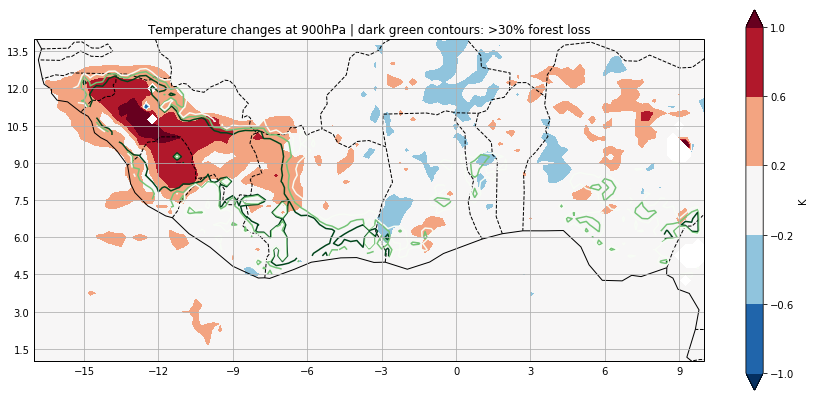

In [302]:
# Check of 900hPa temperatures and deforested area
diff = cur_ds['T_pl']-past_ds['T_pl']
contour = {'data' : veg_diff*100, 'x' : veg_diff.lon, 'y' : veg_diff.lat, 'levels' : [-30, -25,-20], 'cmap' : 'Greens_r'}

draw_map(diff.sel(p_lev=900), diff.lon, diff.lat, title='Temperature changes at 900hPa | dark green contours: >30% forest loss', levels=np.linspace(-1,1,6), extend='both', cmap='RdBu_r', cbar_label="K", contour=contour)
# Between 8-9N, the coastline is relatively perpendicular to incoming wind (and sea breeze circulation), 
# which might make it a good choice for a first cross section check! 

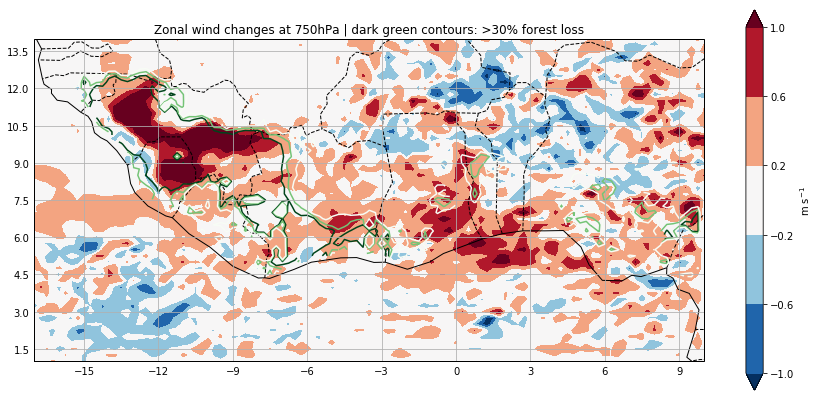

In [303]:
# zonal winds and deforested area
diff = cur_ds['u_pl']-past_ds['u_pl']
draw_map(diff.sel(p_lev=750), diff.lon, diff.lat, title='Zonal wind changes at 750hPa | dark green contours: >30% forest loss', levels=np.linspace(-1,1,6), extend='both', cmap='RdBu_r', cbar_label="m s$^{-1}$", contour=contour)

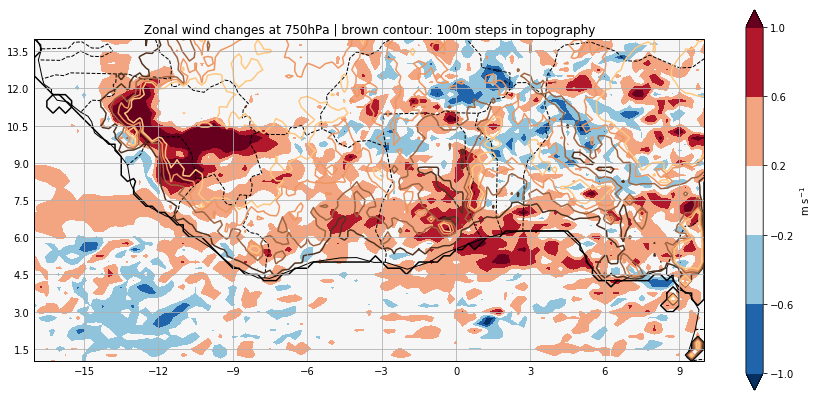

In [375]:
# zonal winds and topography
diff = cur_ds['u_pl']-past_ds['u_pl']
contour = {'data' : ancil_ds['topo'], 'x' : veg_diff.lon, 'y' : veg_diff.lat, 'levels' : np.arange(0,401,100), 'cmap' : 'copper'}
draw_map(diff.sel(p_lev=750), diff.lon, diff.lat, title='Zonal wind changes at 750hPa | brown contour: 100m steps in topography', levels=np.linspace(-1,1,6), extend='both', cmap='RdBu_r', cbar_label="m s$^{-1}$", contour=contour)

# Note: Looking at a zonal cross section around 9N, the terrain rises quickly from 12W towards the East. 
# This will be visible in the winds, too! The strongest change in u wind is visible in deforested complex terrain. 

In [319]:
### Cross-sections

In [361]:
# slice our data for cross sections: around 9N and only up to 600hPa

past_cross = past_ds.sel(lat=slice(8,9), lon=slice(-16,-8), p_lev=slice(975,600)).mean('lat')
cur_cross = cur_ds.sel(lat=slice(8,9), lon=slice(-16,-8), p_lev=slice(975,600)).mean('lat')
vpick=veg_diff.sel(lat=slice(8,9), lon=slice(-16,-8)).mean('lat')
tpick=ancil_ds['topo'].sel(lat=slice(8,9), lon=slice(-16,-8)).mean('lat')

/home/ck/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [352]:
past_cross  # only longitude and pressure levels are left as dimensions

<xarray.Dataset>
Dimensions:  (lon: 33, p_lev: 10)
Coordinates:
  * p_lev    (p_lev) float64 975.0 950.0 925.0 900.0 ... 750.0 700.0 650.0 600.0
  * lon      (lon) float64 -16.0 -15.75 -15.5 -15.25 ... -8.75 -8.5 -8.25 -8.0
Data variables:
    w_pl     (p_lev, lon) float64 -0.001853 -0.002161 ... -0.00941 -0.00887
    u_pl     (p_lev, lon) float64 4.217 4.255 4.252 ... -6.528 -6.541 -6.47
    v_pl     (p_lev, lon) float64 -0.8886 -0.6124 -0.3599 ... 0.8605 0.6643
    T_pl     (p_lev, lon) float64 295.4 295.4 295.5 295.6 ... 275.0 274.9 274.8
    q_pl     (p_lev, lon) float64 0.01262 0.01274 0.01286 ... 0.005295 0.005319
    rh_pl    (p_lev, lon) float64 73.22 73.48 73.76 74.48 ... 72.0 73.25 74.11

In [353]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show() 

In [392]:
# "current zonal wind" wind vectors
uano = cur_cross['u_pl']
wano = cur_cross['w_pl']*10  # multiplied by 10 since vertical component is very small compared to horizontal one
st=2
sarrow = 3
xquiv = cur_cross.lon#[sarrow::st]
yquiv = cur_cross.p_lev#[sarrow::st]

uu = (uano)#[::, sarrow::st]  
ww = (wano)#[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

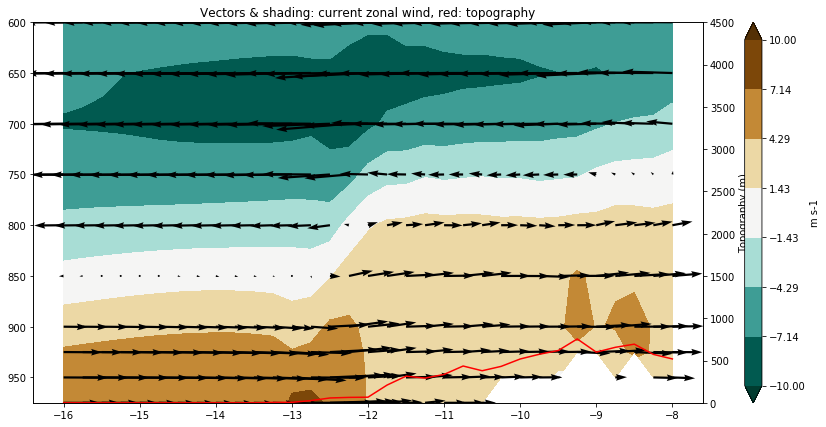

In [393]:
# zonal wind, currently and wind differences
twinx = {'x' : past_cross.lon, 'y' : tpick, 'color' : 'red', 'ylabel' : 'Topography (m)', 'ylim' : (0,4500)}

data = (cur_cross['u_pl'] - past_cross['u_pl'])
draw_cross((cur_cross['u_pl']), past_cross.lon, past_cross.p_lev, cmap='BrBG_r', levels=np.linspace(-10,10,8), 
           quiver=qin, cbar_label='m s-1', twinx=twinx, title='Vectors & shading: current zonal wind, red: topography')

In [358]:
# differences in wind vectors
uano = cur_cross['u_pl']-past_cross['u_pl']
wano = cur_cross['w_pl']-past_cross['w_pl']*10
st=30
sarrow = 4
xquiv = cur_cross.lon#[sarrow::st, sarrow::st]
yquiv = cur_cross.p_lev#[sarrow::st, sarrow::st]

uu = (uano)#[sarrow::st, sarrow::st]  # wind differences
ww = (wano)#[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

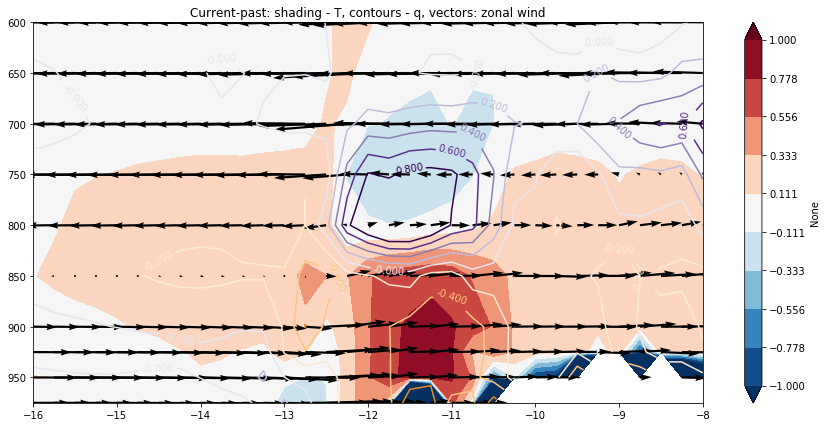

In [396]:
# temperature and moisture check
data = (cur_cross['q_pl'] - past_cross['q_pl'])*1000
contour = {'data' : data, 'x' : past_cross.lon, 'y' : past_cross.p_lev, 'levels' : np.arange(-1,1,0.2), 'cmap' : 'PuOr'}
draw_cross((cur_cross['T_pl'] - past_cross['T_pl']), past_cross.lon, past_cross.p_lev, cmap='RdBu_r', 
           levels=np.linspace(-1,1,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

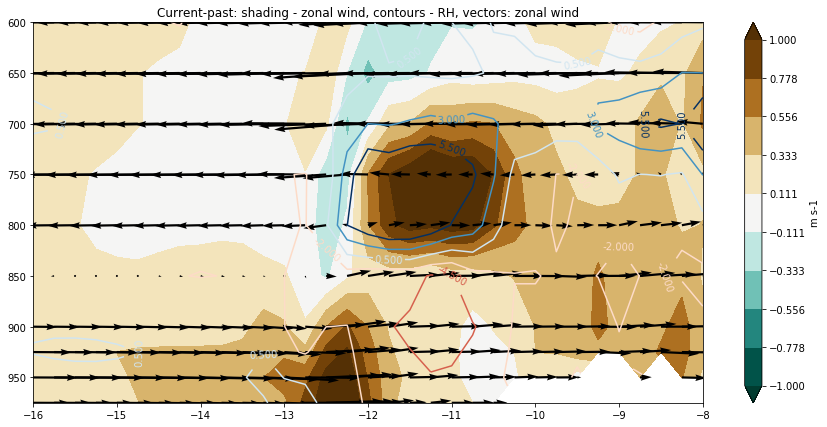

In [395]:
# zonal wind shading and relative humidity
data = (cur_cross['rh_pl']-past_cross['rh_pl'])
contour = {'data' : data, 'x' : data.lon, 'y' : data.p_lev, 'levels' : np.arange(-7,7.1,2.5), 'cmap' : 'RdBu'}
draw_cross((cur_cross['u_pl']-past_cross['u_pl']), past_cross.lon, past_cross.p_lev, cmap='BrBG_r', levels=np.linspace(-1,1,10), 
           quiver=qin, contour=contour, title='Current-past: shading - zonal wind, contours - RH, vectors: zonal wind', cbar_label='m s-1')

Other things to check: changes in shallow convection / shallow cloud development? Impact on incoming radiation? ..